## **0. Integrantes del equipo de trabajo**
---

*   **Juan Diego Mogollón Oviedo - CC 1.052.410.400**
*   **Diego Alejandro Ferro Martínez - CC 1019024233**
*   **Martin Fernando Zorrilla - CC 94416377**

## **1. Entendimiento del negocio**
---

### **1.1. Objetivos del negocio y situación actual:**

---


El proyecto se enmarca dentro la climatología y su propósito específico es mejorar los insumos de pronóstico de precipitación, mediante la validación de la data real con la pronosticada con el propósito de servir insumos más precisos para el entrenamiento de modelos de predicción meteorológica.  

####Beneficiarios del proyecto:

  * **Agencias de gestión de desastres naturales:** podrán contar con mayor precisión y confiabilidad para la toma de decisiones informadas y ágiles para responder a cambios climáticos.  
   
  * **Comunidades Vulnerables:** Las comunidades en zonas geográficas con riesgo de presentarse un desastre natural, recibirán alertas de manera más precisa y oportuna. Agilizaría y volvería más eficiente mitigación del riesgo sobre dichas comunidades.
   
  * **Gobierno y/o autoridades locales**: Podrán planificar y coordinar de manera más efectiva la respuesta en emergencias. Adicionalmente mejora la gestión y asignación de recursos en estas entidades para la atención de emergencia.
   
  * **Investigación:** científicos e investigadores contarán con validaciones precisas contributyendo al mejoramiento de modelos climáticos de pronóstico y comprensión de tendencias.

####Problema:
Falta de información de la validacion de exactitud de los datos o insumos de pronóstico de precipitación, los cuales son requeridos por los modelos de alertas por desastres naturales.

####Justificación:

*   Mejorar la calidad de los insumos para la toma de desiciones en la mitigación y gestion de riesgo de desastres.
*   Retroalimentar modelos de pronostico meteorológico para validacion y mejora continua.
*   Mostrar puntos de referencia para el análisis de otras variables meteorologicas.
*   Conocer con mas detalle los insumos a partir de métodos de estastica descriptiva.
*   Visualizar de manera intuitiva los datos reales y pronosticados para su mayor compresión.



### **1.2. Objetivo del proyecto:**

---


####Objetivo General
Validar y visualizar la exactitud de los datos e insumos de pronóstico de precipitación acumulada de 24 horas en contraste con los datos reales de estaciones meteorologicas.

####Objetivos Especificos
*   Establecer un método para el acceso y descarga de los insumos de pronóstico meteorológico y datos reales de estaciones.
*   Aplicar métodos estadísticos para obtener resultados relevantes en la validación del pronóstico meteorológico.
*   Visualizar los resultados estadisticos por medio de tablas o gráficas específicas.



### **1.3. Planeación del proyecto:**

---


Cada una de las fases del proyecto se dividieron en tareas mas pequeñas de ejecucion. Cada Fase corresponderá a una epica siguiendo la metodologia de SCRUM con una serie de historias a completar que consisten en entregables que hacen parte del Notebook final. Las fases se presentan a continuación:


1. Entendimiento del Negocio: Aproximación inicial de ruta del proyecto: 21-Feb/2024

2. Carga, Descripción de Datos, Aplicación estadistica exploratoria. Análisis de datos faltantes: 28-Feb/2024

3. Ejecución de Pruebas de Correlación, Construcción de Intervalos de Confianza. 6-Mar/2024

4. Visualización de Datos. Realización de Graficos Avanzados. 13-Mar/2024

5. Finalización Discusion de Resultados / Presentacion-Video Final. 20-Mar/2024

Las definiciones en detalle de la planeación y ejecucion semanal será registrada en este tablero de Trello, por cada uno de los miembros del equipo:  

https://trello.com/b/rhiZzx4O/kanban-activities

# **Librerias**

In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 12.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
from datetime import datetime, timedelta
import os
import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from ipywidgets import interact
import multiprocessing as mp
import pandas as pd
import requests
import rasterio
import seaborn as sns
from scipy import stats
import scipy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import zipfile

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## **2. Entendimiento de los datos**
---

### **2.1. Adquisición e integración de los datos:**

---


#### Datasets


*   https://bart.ideam.gov.co/ospa/PronosticosCol/SmartMet/tif/
*   http://bart.ideam.gov.co/wrfideam/new_modelo/WRF00COLOMBIA/tif/
*  http://dhime.ideam.gov.co/atencionciudadano/

*  Datos de estaciones automaticas privado (host='172.16.50.20',port=8080, user='', catalog='raw', schema='cassandra')

EL dataset de datos reales corresponde al registro de 1075 estaciones metereologicas distribuidas en el pais , con las columnas correspondientes a Longitud, latitud elevación, codigo de identificación de la estación, municipio departamento, y las columnas correspondientes al registro pluvliometrico de la estacion por dias.

In [ ]:
# Descarga de los archivos raster del mes de enero de 2024
def descargar_raster(fecha_inicio: datetime, dias: int):

    formato_url = "http://bart.ideam.gov.co/wrfideam/new_modelo/WRF00COLOMBIA/tif/geoTIFF{}00Z.zip"
    formato_archivo = "ACUM24HPREC_MM_{}_fcst_{}.tif"

    for dia in range(dias):
        fecha_inicio += timedelta(days=1)
        year, month, day = fecha_inicio.strftime("%d-%m-%Y").split("-")
        codigo = f"{year}{month}{day}"
        url = formato_url.format(codigo)
        archivo = formato_archivo.format(codigo,codigo)

        respuesta = requests.get(url)
        respuesta.raise_for_status()
        archivo_zip = zipfile.ZipFile(io.BytesIO(respuesta.content))
        archivo_zip.extract(archivo,'/content/drive/MyDrive/Proyecto Analisis y Visualizacion de Datos/archivos_raster/')

fecha_inicial = datetime(2023, 12, 31)
descargar_raster(fecha_inicial, 31)


In [ ]:
# Cargar datos reales de estaciones meteorologicas
datos_estaciones = pd.read_csv('/content/drive/MyDrive/Proyecto Analisis y Visualizacion de Datos/Datos/precipitacion_ene_2024.csv')
# Leer el reporte de estaciones filtrado
# datos_validacion = pd.read_csv('/content/drive/MyDrive/Proyecto Analisis y Visualizacion de Datos/Datos/reporte_datos_filtrado.csv',sep=';')

In [ ]:
# Cargar datos del raster del 01 de enero de 2024
with rasterio.open("/content/drive/MyDrive/Proyecto Analisis y Visualizacion de Datos/archivos_raster/ACUM24HPREC_MM_01012024_fcst_01012024.tif") as src:
    # Lee el contenido del raster como una matriz numpy
    raster_values = src.read(1)
    # Obtiene las coordenadas de las esquinas del raster
    bounds = src.bounds
    # Obtiene la resolución del raster
    res = src.res

### **2.2. Análisis exploratorio de los datos:**

---


In [ ]:
datos_estaciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074 entries, 0 to 1073
Data columns (total 39 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LON         1041 non-null   object 
 1   LAT         1041 non-null   object 
 2   ELEV        1012 non-null   float64
 3   COD-DHIME   917 non-null    float64
 4   Unnamed: 4  0 non-null      float64
 5   ESTACION    1066 non-null   object 
 6   MUNICIPIO   1035 non-null   object 
 7   DPTO        1043 non-null   object 
 8   1           722 non-null    object 
 9   2           719 non-null    object 
 10  3           727 non-null    object 
 11  4           724 non-null    object 
 12  5           721 non-null    object 
 13  6           711 non-null    object 
 14  7           716 non-null    object 
 15  8           721 non-null    object 
 16  9           725 non-null    object 
 17  10          728 non-null    object 
 18  11          721 non-null    object 
 19  12          728 non-null   

In [ ]:
# Arreglo numpy de los datos de precipitacion acumulada del raster
print(raster_values)
print(f"Tipo de datos de la matriz : {raster_values.dtype}")
print(f"El tamaño de la matriz es : {raster_values.shape}")
print(f"Las coordenadas limite son : izquierda - {bounds.left}, derecha - {bounds.right}, arriba - {bounds.top}, abajo - {bounds.bottom}")
print(f"La resolución del raster es : {res} grados decimales en x, y" )
print(f"La proyección del raster es: {src.crs}")

[[1.7138470e+00 1.0104890e+00 1.1746273e+00 ... 2.7663492e-02
  2.8825454e-02 2.2484982e-01]
 [3.2324617e+00 3.0347116e+00 3.9782369e+00 ... 6.1684865e-01
  5.7978630e-01 4.6552509e-02]
 [3.5280900e+00 3.8934147e+00 3.4212985e+00 ... 9.2996770e-01
  9.4538844e-01 6.3031614e-02]
 ...
 [2.1040681e-01 4.4394629e-03 2.7855141e-03 ... 4.0286023e-02
  3.5778351e-02 1.7190218e-02]
 [2.6661652e-01 4.1668797e-03 6.7177089e-03 ... 4.0870376e-02
  3.0202247e-02 2.0284448e-02]
 [2.3918629e-01 6.5654810e-03 3.4481313e-03 ... 2.0592449e-02
  2.7822021e-02 1.9681921e-02]]
Tipo de datos de la matriz : float32
El tamaño de la matriz es : (249, 249)
Las coordenadas limite son : izquierda - -85.38614999999999, derecha - -62.90144999999998, arriba - 15.748899999999999, abajo - -6.511699999999998
La resolución del raster es : (0.0903, 0.0894) grados decimales en x, y
La proyección del raster es: EPSG:4326


In [ ]:
# Problema 1 Ausencia de datos
ausencia_datos = datos_estaciones.isnull().sum()

# Impresion de resultados
print(f"Ausencia de datos:\n{ausencia_datos}")
#print(ausencia_datos)

#Problema 2 - Mezcla de departamentos en mayuscula y minuscula por diversidad de formatos en departamento
cantidad_valores_dpto = datos_estaciones['DPTO'].nunique()

print(f"Cantidad de valores únicos en la columna 'DPTO': {cantidad_valores_dpto}")

# Problema 3- Algunos valores de las precipitaciones son string y no pueden ser convertidos a float
# Vamos a crear un DataFrame con los resultados
valores_string_por_columna = datos_estaciones.iloc[:, 8:39].applymap(lambda x: isinstance(x, str)).sum()

# Construir la Serie con el label de la columna y la cantidad de valores string
serie_resultado = pd.Series(valores_string_por_columna.values, index=datos_estaciones.columns[8:39])

# Imprimir los resultados
print("Cantidad de valores tipo string por columna:")
print(serie_resultado)

Ausencia de datos:
LON             33
LAT             33
ELEV            62
COD-DHIME      157
Unnamed: 4    1074
ESTACION         8
MUNICIPIO       39
DPTO            31
1              352
2              355
3              347
4              350
5              353
6              363
7              358
8              353
9              349
10             346
11             353
12             346
13             356
14             343
15             346
16             346
17             344
18             342
19             353
20             354
21             345
22             346
23             348
24             341
25             342
26             348
27             358
28             348
29             350
30             353
31             359
dtype: int64
Cantidad de valores únicos en la columna 'DPTO': 50
Cantidad de valores tipo string por columna:
1     722
2     719
3     727
4     724
5     721
6     711
7     716
8     721
9     725
10    728
11    721
12    728
13    718


### **2.3. Descripciones generales:**

---


El dataset contiene 1075 registros correpondientes a las estaciones metereológicas. Es un DataFrame con 1074 entradas y 39 columnas.
Las columnas incluyen información como longitud (LON), latitud (LAT), elevación (ELEV), código de estación (COD-DHIME), nombre de estación (ESTACION), municipio (MUNICIPIO), departamento (DPTO), y varias columnas etiquetadas con números del 1 al 31.

Las columnas etiquetadas con números  representan datos diarios de observaciones meteorológicas de precipitación.

Hay varios valores faltantes (NaN) en todo el conjunto de datos, indicados por "Non-Null Count" siendo menor que el número total de entradas.

Los tipos de datos incluyen números de punto flotante (float64) para algunas columnas y objetos para otras.

**PROBLEMAS IDENTIFICADOS**
Basicamente existen tres tipos de problemas que pudimos encontrar:

**Ausencia de datos**
Algunas estaciones no registran mediciones, con lo cual no se identifica si estan inactivas o los operadores no ingresaron los datos.

**Diversidad de formatos**
Como es de conocimiento general, Colombia cuenta con 32 departamentos. Sin embargo, la cantidad de valores en la columna 'DPTO' es de 50, por lo que valores con mayuscula o minuscula del mismo departamento pudieran ser considerados como diferentes.

**Valores no-numericos en precipitaciones**
Dado que el ingreso de datos es manual, para el formato decimal en algunos casos se utiliza coma (,) lo que se interpreta como un valor string, que imposibilita su analisis descriptivo.

### **2.4. Análisis con estadistica descriptiva:**

---


In [ ]:
datos_estaciones = datos_estaciones.copy()

# SELECCION DE LOS DIAS Y ESTACIONES
estaciones_vs_dias = datos_estaciones.loc[:, '1':'31']
# print(estaciones_vs_dias)

# Limpieza de filas nulas
estaciones_vs_dias = estaciones_vs_dias.dropna()
estaciones_vs_dias

def convertir_a_float(valor):
    if isinstance(valor, float):
        return valor
    try:
        return float(valor.replace(',', '.'))
    except ValueError:
        return pd.NA

estaciones_vs_dias = estaciones_vs_dias.applymap(convertir_a_float)
media_estaciones = estaciones_vs_dias.mean(axis=1)
print(f'Media por estación:\n{media_estaciones}')

Media por estación:
1      1.616129
2      1.296774
3      0.000000
4      0.000000
6      0.000000
         ...   
959    0.000000
960    0.487097
961    0.038710
962    0.638710
963    1.725806
Length: 595, dtype: float64


In [ ]:
desviacion_estandar_por_estacion = estaciones_vs_dias.std(axis=1)
print(f'Desviación estandar por estación:\n {desviacion_estandar_por_estacion}')

Desviación estandar por estación:
 1      4.762639
2      2.265463
3      0.000000
4      0.000000
6      0.000000
         ...   
959    0.000000
960    1.552791
961    0.152047
962    1.991595
963    5.141074
Length: 595, dtype: float64


### **2.5. Visualización de datos estáticos:**

---


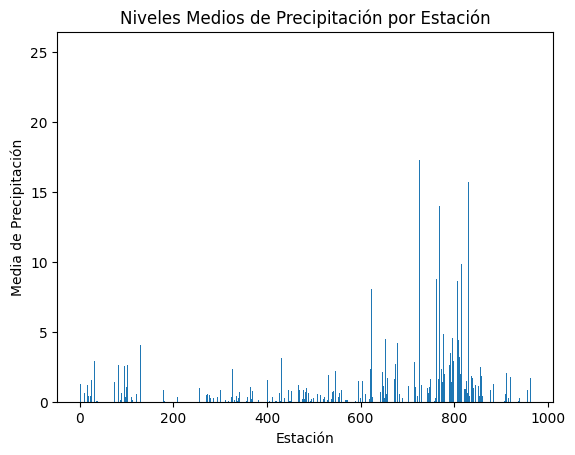

In [ ]:
plt.bar(estaciones_vs_dias.index, media_estaciones)
plt.xlabel('Estación')
plt.ylabel('Media de Precipitación')
plt.title('Niveles Medios de Precipitación por Estación')
plt.show()

## **3. Preparación de los datos**
---

### **3.1. Limpieza de los datos:**

---


In [ ]:
# Convertir a las columnas a variables numéricas
cols = ['LON', 'LAT'] + [str(i) for i in range(1, 32)]
datos_estaciones[cols] = datos_estaciones[cols].applymap(lambda x: pd.to_numeric(x.replace(',', '.') if isinstance(x, str) else x, errors='coerce'))
print(f"Tamaño del dataframe original : {datos_estaciones.shape}")
datos_estaciones.head(3)

Tamaño del dataframe original : (1074, 39)


,LON,LAT,ELEV,COD-DHIME,Unnamed: 4,ESTACION,MUNICIPIO,DPTO,1,2,...,22,23,24,25,26,27,28,29,30,31
0,NaN,NaN,NaN,NaN,NaN,R E G I O N C A R I B E,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-81.72,12.58,1.0,17015010.0,NaN,APTO GUSTAVO ROJA PINILLA,"Apto, San Andrés",SAN ANDRES PROVIDENCIA Y STA C,0.3,3.8,...,0.2,0.8,0.7,3.5,0.0,1.9,2.0,0.0,3.5,26.5
2,-81.35,13.37,1.0,17025020.0,NaN,APTO EL EMBRUJO,"Apto, Providencia",SAN ANDRES PROVIDENCIA Y STA C,0.5,0.1,...,0.0,4.7,1.7,2.4,0.0,5.8,4.1,0.0,10.2,0.1


In [ ]:
# Eliminar filas con valores faltantes en las columnas LON y LAT
datos_estaciones_filtrado = datos_estaciones.dropna(subset=["LON","LAT"])

# Eliminar la columna 'Unnamed: 4'
print(f"Numero de valores faltantes en la columna 'Unnamed: 4' : {datos_estaciones['Unnamed: 4'].isna().sum()}")
datos_estaciones_filtrado = datos_estaciones_filtrado.drop(columns=['Unnamed: 4'])

# Eliminar filas con valores faltantes en todos los dias del mes
datos_estaciones_filtrado = datos_estaciones_filtrado.dropna(subset=[str(i) for i in range(1, 32)], how="all")
print(f"Tamaño del dataframe filtrado : {datos_estaciones_filtrado.shape}")

datos_estaciones_filtrado.head(3)

Numero de valores faltantes en la columna 'Unnamed: 4' : 1074
Tamaño del dataframe filtrado : (752, 38)


,LON,LAT,ELEV,COD-DHIME,ESTACION,MUNICIPIO,DPTO,1,2,3,...,22,23,24,25,26,27,28,29,30,31
1,-81.72,12.58,1.0,17015010.0,APTO GUSTAVO ROJA PINILLA,"Apto, San Andrés",SAN ANDRES PROVIDENCIA Y STA C,0.3,3.8,0.1,...,0.2,0.8,0.7,3.5,0.0,1.9,2.0,0.0,3.5,26.5
2,-81.35,13.37,1.0,17025020.0,APTO EL EMBRUJO,"Apto, Providencia",SAN ANDRES PROVIDENCIA Y STA C,0.5,0.1,0.2,...,0.0,4.7,1.7,2.4,0.0,5.8,4.1,0.0,10.2,0.1
3,-74.23,11.13,4.0,15015050.0,APTO SIMON BOLIVAR (14 Km en linea recta al oc...,"Apto, Santa Marta (14 Km en linea recta al occ...",MAGDALENA,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **3.2. Selección de las caracteristicas:**

---


In [ ]:
# Re estructurar el dataframe a partir de la fecha
df_final = datos_estaciones_filtrado.melt(id_vars=['LON', 'LAT', 'ELEV', 'COD-DHIME', 'ESTACION', 'MUNICIPIO', 'DPTO'],
                  var_name='DIA', value_name='DATO_ESTACION')
df_final['FECHA'] = pd.to_datetime('2024-01-' + df_final['DIA'])

# Eliminar la columna DIA
df_final = df_final.drop(columns=['DIA'])
print(f"Tamaño del dataframe final : {df_final.shape}")
df_final.head(3)

Tamaño del dataframe final : (23312, 9)


,LON,LAT,ELEV,COD-DHIME,ESTACION,MUNICIPIO,DPTO,DATO_ESTACION,FECHA
0,-81.72,12.58,1.0,17015010.0,APTO GUSTAVO ROJA PINILLA,"Apto, San Andrés",SAN ANDRES PROVIDENCIA Y STA C,0.3,2024-01-01
1,-81.35,13.37,1.0,17025020.0,APTO EL EMBRUJO,"Apto, Providencia",SAN ANDRES PROVIDENCIA Y STA C,0.5,2024-01-01
2,-74.23,11.13,4.0,15015050.0,APTO SIMON BOLIVAR (14 Km en linea recta al oc...,"Apto, Santa Marta (14 Km en linea recta al occ...",MAGDALENA,0.0,2024-01-01


### **3.3. Preprocesamiento y transformación:**

---


In [ ]:
# Función para obtener el valor del ráster en una coordenada específica
def get_values_for_date(group):
    date = group['FECHA'].iloc[0]
    date_str = date.strftime('%d%m%Y')
    file_path = f"/content/drive/MyDrive/Proyecto Analisis y Visualizacion de Datos/archivos_raster/ACUM24HPREC_MM_{date_str}_fcst_{date_str}.tif"

    if not os.path.exists(file_path):
        return pd.Series([None]*len(group), index=group.index)

    with rasterio.open(file_path) as src:
        dataset_values = src.read(1)
        bounds = src.bounds
        res = src.res
    dataset_lon, dataset_lat = np.meshgrid(
        np.arange(bounds.left + res[0]/2, bounds.right + res[0]/2, res[0]),
        np.arange(bounds.top - res[1]/2, bounds.bottom - res[1]/2, -res[1])
    )

    values = []
    for _, row in group.iterrows():
        index_rowy = np.abs(dataset_lat[:, 0].astype(float) - row['LAT']).argmin()
        index_colx = np.abs(dataset_lon[0, :].astype(float) - row['LON']).argmin()
        values.append(dataset_values[index_rowy, index_colx])

    return pd.Series(values, index=group.index)

# Crear un pool de procesos
with mp.Pool(mp.cpu_count()) as pool:
    # Dividir el DataFrame en grupos por fecha
    groups = [group for _, group in df_final.groupby('FECHA')]
    # Aplicar la función a cada grupo en paralelo
    results = pool.map(get_values_for_date, groups)

# Combinar los resultados en una sola serie
df_final['DATO_RASTER'] = pd.concat(results)

# Redondear la columna 'DATO_RASTER' a 1 decimal
df_final['DATO_RASTER'] = df_final['DATO_RASTER'].round(1)

# Reordenar las columnas
cols = ['FECHA'] + [col for col in df_final.columns if col != 'FECHA']
df_final = df_final[cols]

df_final = df_final.dropna(subset=["DATO_ESTACION","DATO_RASTER"])

print(f"Tamaño del dataframe final : {df_final.shape}")
df_final.head(3)

Tamaño del dataframe final : (22447, 10)


,FECHA,LON,LAT,ELEV,COD-DHIME,ESTACION,MUNICIPIO,DPTO,DATO_ESTACION,DATO_RASTER
0,2024-01-01,-81.72,12.58,1.0,17015010.0,APTO GUSTAVO ROJA PINILLA,"Apto, San Andrés",SAN ANDRES PROVIDENCIA Y STA C,0.3,0.8
1,2024-01-01,-81.35,13.37,1.0,17025020.0,APTO EL EMBRUJO,"Apto, Providencia",SAN ANDRES PROVIDENCIA Y STA C,0.5,0.6
2,2024-01-01,-74.23,11.13,4.0,15015050.0,APTO SIMON BOLIVAR (14 Km en linea recta al oc...,"Apto, Santa Marta (14 Km en linea recta al occ...",MAGDALENA,0.0,0.0


## **4. Análisis de datos**
---

### **4.1. Técnicas estadisticas tradicionales:**

---


<ipython-input-75-bc952d17cd00>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=columnas_seleccionadas.melt(var_name='Día', value_name='Valor'),


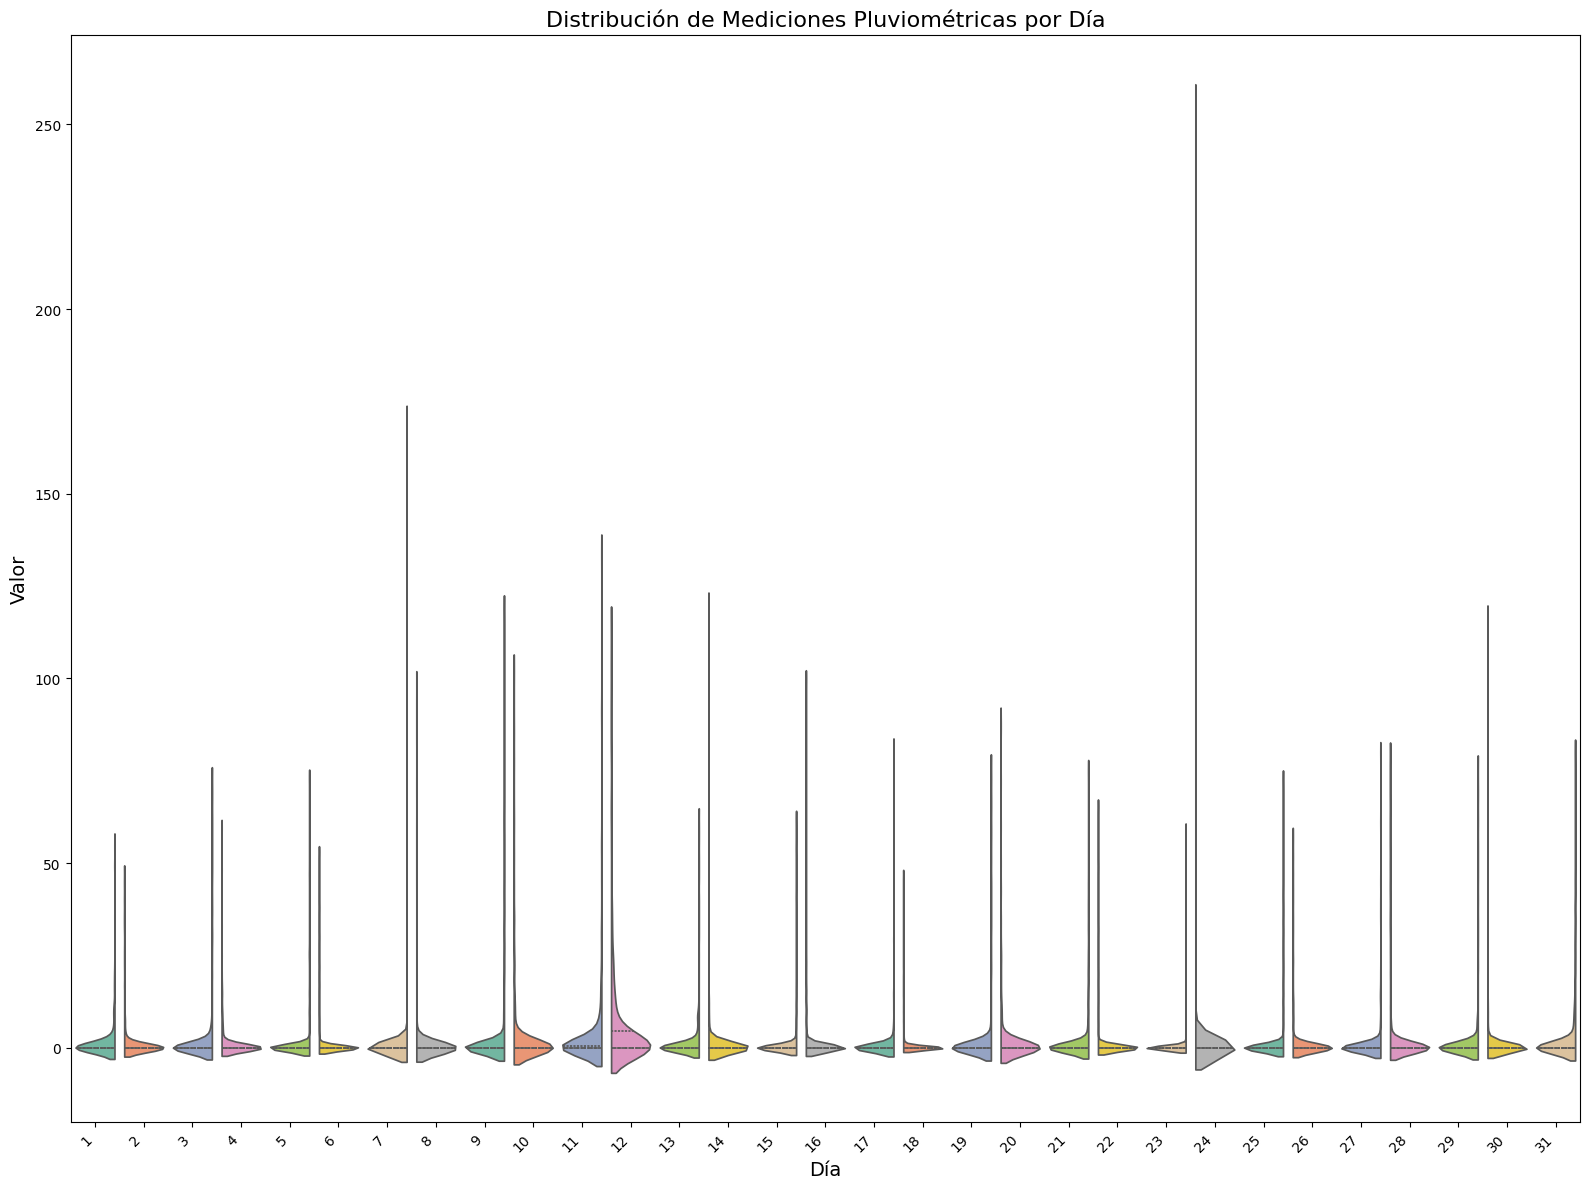

In [ ]:
plt.figure(figsize=(16, 12))

# Crear un gráfico de violín para todas las columnas de mediciones con colores por índice (estación)
sns.violinplot(data=columnas_seleccionadas.melt(var_name='Día', value_name='Valor'),
               x='Día', y='Valor', split=True, inner='quartile', palette='Set2')

plt.xlabel('Día', fontsize=14)
plt.ylabel('Valor', fontsize=14)
plt.title('Distribución de Mediciones Pluviométricas por Día', fontsize=16)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

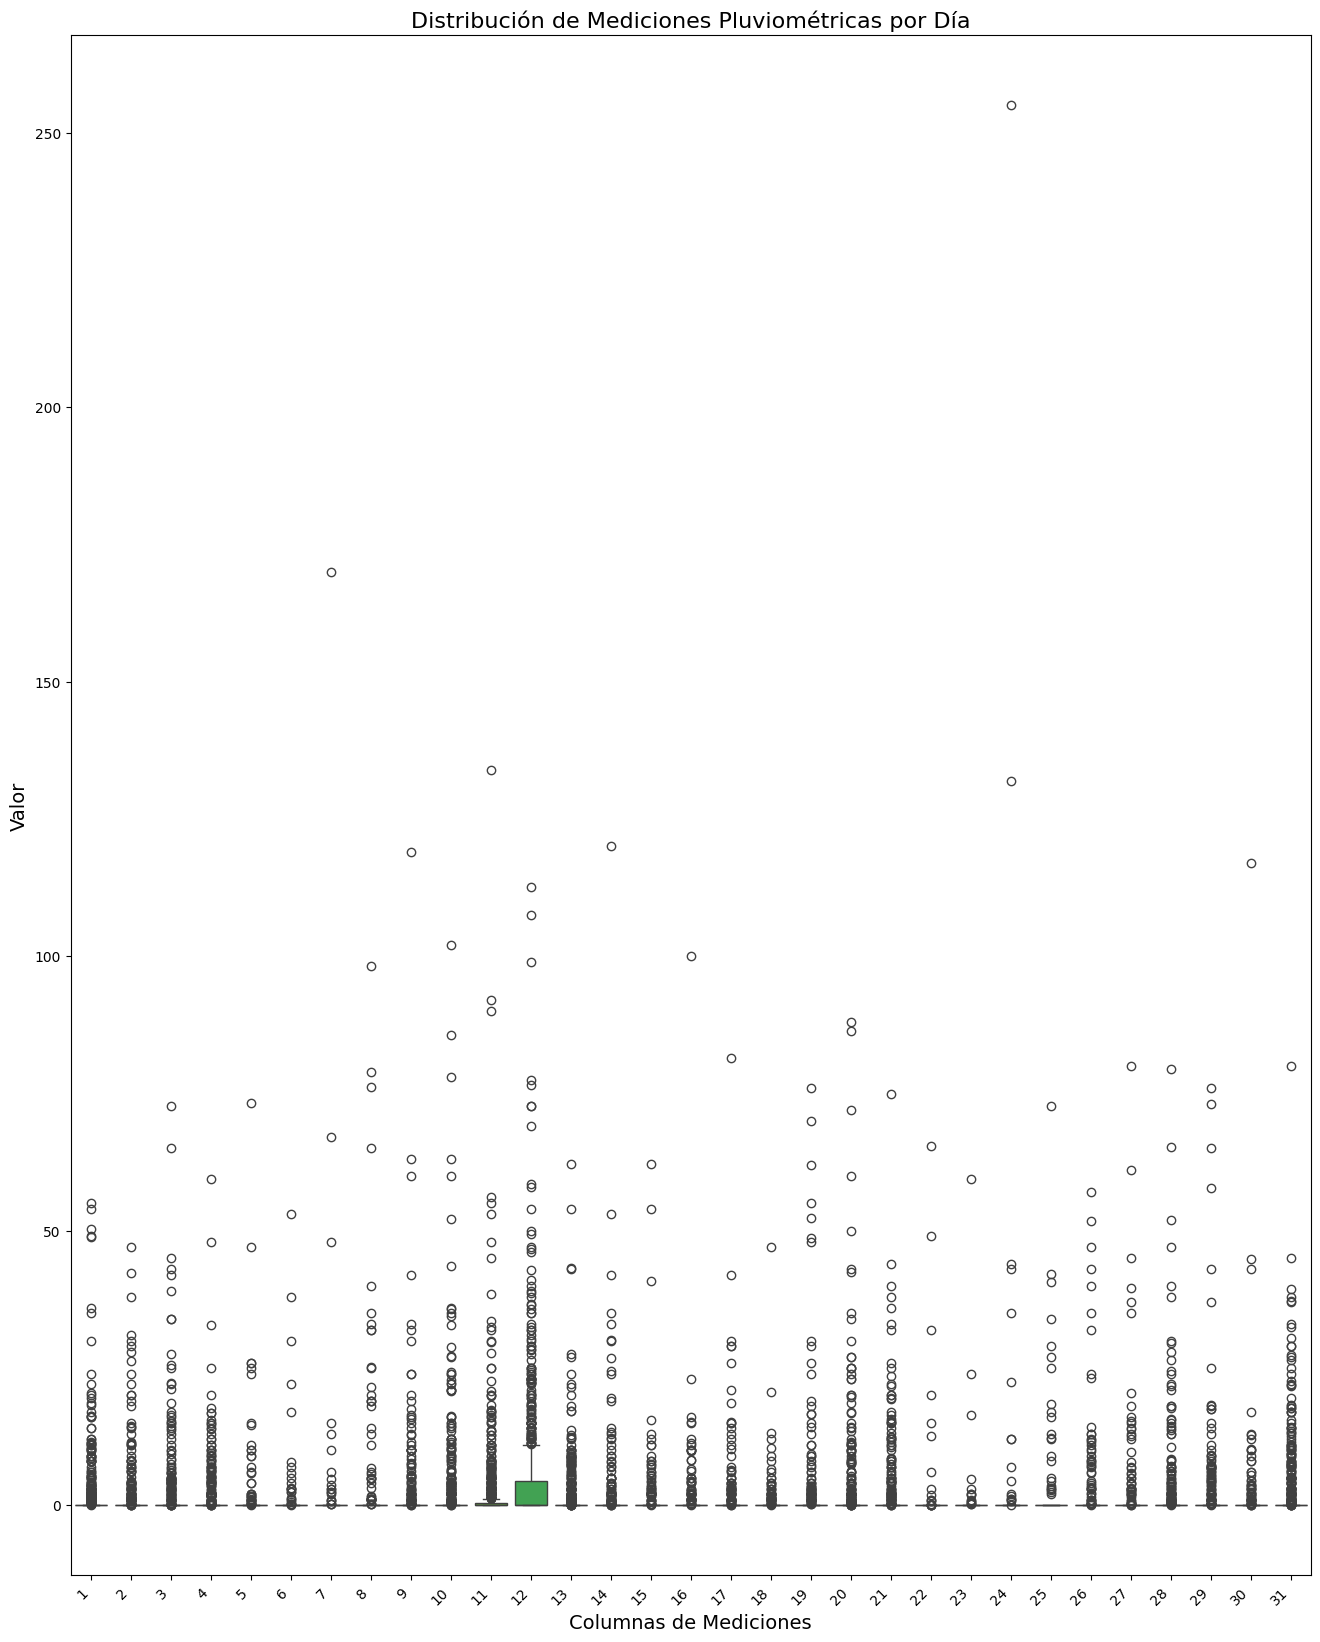

In [ ]:
df_estaciones_dia = datos_estaciones_filtrado.copy()
columnas_seleccionadas = df_estaciones_dia.loc[:, '1':'31']

# Configurar el tamaño del gráfico
plt.figure(figsize=(16, 20))

# Crear un gráfico de caja para todas las columnas de mediciones
sns.boxplot(data=columnas_seleccionadas, )

# Añadir etiquetas y título
plt.xlabel('Distribucion diaria de precipitacion', fontsize=14)
plt.ylabel('Valores (mm)', fontsize=14)
plt.title('Distribución de Mediciones Pluviométricas por Día', fontsize=16)

plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.show()

In [ ]:
datos_validacion = df_final
# Calcular el error
error = datos_validacion['DATO_ESTACION'] - datos_validacion['DATO_RASTER']

# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(datos_validacion['DATO_ESTACION'], datos_validacion['DATO_RASTER'])

# Calcular la raíz del error cuadrático medio (RMSE)
rmse = np.sqrt(mean_squared_error(datos_validacion['DATO_ESTACION'], datos_validacion['DATO_RASTER']))

print(f"El error absoluto medio (MAE) es: {round(mae,1)} mm")
print(f"La raíz del error cuadrático medio (RMSE) es: {round(rmse,1)} mm")

El error absoluto medio (MAE) es: 2.4 mm
La raíz del error cuadrático medio (RMSE) es: 8.4 mm


In [ ]:
datos_validacion_sin_ceros = datos_validacion.loc[datos_validacion['DATO_ESTACION'] != 0]

# Percentiles
percentiles = datos_validacion_sin_ceros['DATO_ESTACION'].quantile([0.7, 0.8, 0.9, 0.95, 0.99])

# Definir las categorías
bins = [-np.inf] + [0.1] + list(percentiles.values) + [np.inf]
labels = ["Tiempo Seco","Muy Ligera", "Ligera", "Moderada", "Fuerte", "Muy Fuerte", "Torrencial"]

# Crear las nuevas columnas con las categorías
datos_validacion['lluvia_observada'] = pd.cut(datos_validacion['DATO_ESTACION'], bins=bins, labels=labels)
datos_validacion['lluvia_pronosticada'] = pd.cut(datos_validacion['DATO_RASTER'], bins=bins, labels=labels)

print(f"Umbrales de lluvia:\n{percentiles}")
datos_validacion.head(5)

Umbrales de lluvia:
0.70     8.700
0.80    13.500
0.90    24.000
0.95    38.000
0.99    76.064
Name: DATO_ESTACION, dtype: float64


,FECHA,LON,LAT,ELEV,COD-DHIME,ESTACION,MUNICIPIO,DPTO,DATO_ESTACION,DATO_RASTER,lluvia_observada,lluvia_pronosticada
0,2024-01-01,-81.72,12.58,1.0,17015010.0,APTO GUSTAVO ROJA PINILLA,"Apto, San Andrés",SAN ANDRES PROVIDENCIA Y STA C,0.3,0.8,Muy Ligera,Muy Ligera
1,2024-01-01,-81.35,13.37,1.0,17025020.0,APTO EL EMBRUJO,"Apto, Providencia",SAN ANDRES PROVIDENCIA Y STA C,0.5,0.6,Muy Ligera,Muy Ligera
2,2024-01-01,-74.23,11.13,4.0,15015050.0,APTO SIMON BOLIVAR (14 Km en linea recta al oc...,"Apto, Santa Marta (14 Km en linea recta al occ...",MAGDALENA,0.0,0.0,Tiempo Seco,Tiempo Seco
3,2024-01-01,-75.52,10.19,2.0,14015080.0,APTO RAFAEL NUNEZ,"Apto, Cartagena",BOLIVAR,0.0,1.3,Tiempo Seco,Muy Ligera
4,2024-01-01,-72.92,11.53,4.0,15065180.0,APTO ALM PADILLA,"Apto, Riohacha",LA GUAJIRA,0.0,0.0,Tiempo Seco,Tiempo Seco


In [ ]:
# Crear la tabla de contingencia
tabla_contingencia = pd.crosstab(datos_validacion['lluvia_observada'], datos_validacion['lluvia_pronosticada'], normalize='index')

# Convertir a porcentaje
tabla_contingencia = tabla_contingencia * 100
tabla_contingencia

lluvia_pronosticada,Tiempo Seco,Muy Ligera,Ligera,Moderada,Fuerte,Muy Fuerte,Torrencial
lluvia_observada,,,,,,,
Tiempo Seco,50.181415,46.820198,1.285023,0.982665,0.423302,0.282201,0.025197
Muy Ligera,10.858726,67.700831,7.423823,7.534626,3.213296,2.271468,0.997230
Ligera,7.547170,67.169811,8.679245,7.547170,5.283019,2.641509,1.132075
Moderada,13.703704,60.000000,5.185185,12.962963,3.703704,2.592593,1.851852
Fuerte,7.692308,60.000000,12.307692,13.076923,2.307692,3.846154,0.769231
Muy Fuerte,7.547170,50.000000,12.264151,15.094340,6.603774,6.603774,1.886792
Torrencial,0.000000,51.851852,18.518519,18.518519,3.703704,3.703704,3.703704


In [ ]:
label_to_number = {label: number for number, label in enumerate(labels)}
datos_validacion['evaluacion'] = datos_validacion['lluvia_observada'].map(label_to_number).cat.codes - datos_validacion['lluvia_pronosticada'].map(label_to_number).cat.codes
total_predicciones = len(datos_validacion)
total_aciertos = len(datos_validacion[datos_validacion['evaluacion'] == 0])
porcentaje_aciertos = (total_aciertos / total_predicciones) * 100

print(f'El porcentaje de aciertos es: {round(porcentaje_aciertos,1)}%')

El porcentaje de aciertos es: 50.1%


In [ ]:
# Conteo por los resultados de datos observados Percentage Correct
datos_validacion['aciertos'] = (datos_validacion['lluvia_observada'] == datos_validacion['lluvia_pronosticada']).astype(int)

total_por_observada = datos_validacion.groupby('lluvia_observada').size()

aciertos_por_observada = datos_validacion.groupby('lluvia_observada')['aciertos'].sum()

desaciertos_por_observada = total_por_observada - aciertos_por_observada

resultados_1 = pd.DataFrame({
    'aciertos': aciertos_por_observada,
    'desaciertos': desaciertos_por_observada,
    'total de observaciones': total_por_observada
})
resultados_1.loc['Totales'] = resultados_1.sum()
resultados_1['Porcentaje de Exactitud (PC)'] = resultados_1['aciertos'] / resultados_1['total de observaciones']
# Muestra los resultados
print(resultados_1)


                  aciertos  desaciertos  total de observaciones  \
lluvia_observada                                                  
Tiempo Seco           9958         9886                   19844   
Muy Ligera            1222          583                    1805   
Ligera                  23          242                     265   
Moderada                35          235                     270   
Fuerte                   3          127                     130   
Muy Fuerte               7           99                     106   
Torrencial               1           26                      27   
Totales              11249        11198                   22447   

                  Porcentaje de Exactitud (PC)  
lluvia_observada                                
Tiempo Seco                           0.501814  
Muy Ligera                            0.677008  
Ligera                                0.086792  
Moderada                              0.129630  
Fuerte                             

In [ ]:
# Conteo por los resultados de datos observados Probability of Detection
datos_validacion['aciertos'] = (datos_validacion['lluvia_pronosticada'] == datos_validacion['lluvia_observada']).astype(int)

total_por_pronosticada = datos_validacion.groupby('lluvia_pronosticada').size()

aciertos_por_pronosticada = datos_validacion.groupby('lluvia_pronosticada')['aciertos'].sum()

desaciertos_por_pronosticada = total_por_pronosticada - aciertos_por_pronosticada

resultados_2 = pd.DataFrame({
    'aciertos': aciertos_por_pronosticada,
    'desaciertos': desaciertos_por_pronosticada,
    'total de pronosticos': total_por_pronosticada
})
resultados_2.loc['Totales'] = resultados_2.sum()
resultados_1['Porcentaje de deteccion (POD)'] = resultados_2['aciertos'] / resultados_2['total de pronosticos']
# Muestra los resultados
print(resultados_2)

                     aciertos  desaciertos  total de pronosticos
lluvia_pronosticada                                             
Tiempo Seco              9958          271                 10229
Muy Ligera               1222         9776                 10998
Ligera                     23          437                   460
Moderada                   35          389                   424
Fuerte                      3          174                   177
Muy Fuerte                  7          117                   124
Torrencial                  1           34                    35
Totales                 11249        11198                 22447


In [ ]:
#Determinar el sesgo entre el pronostico y las observaciones
ocurrencias_pronosticada = datos_validacion['lluvia_pronosticada'].value_counts()
ocurrencias_observada = datos_validacion['lluvia_observada'].value_counts()
ocurrencias_df = pd.DataFrame({
    'datos_pronosticados': ocurrencias_pronosticada,
    'datos_observados': ocurrencias_observada
})

ocurrencias_df['Bias (sesgo)'] = ocurrencias_df['datos_pronosticados'] / ocurrencias_df['datos_observados']

print(ocurrencias_df)


             datos_pronosticados  datos_observados  Bias (sesgo)
Tiempo Seco                10229             19844      0.515471
Muy Ligera                 10998              1805      6.093075
Ligera                       460               265      1.735849
Moderada                     424               270      1.570370
Fuerte                       177               130      1.361538
Muy Fuerte                   124               106      1.169811
Torrencial                    35                27      1.296296


### **4.2. Análisis de correlación y/o análisis de regresión:**

---


Correlación entre precipitación real y pronosticada: 0.20809247175810366


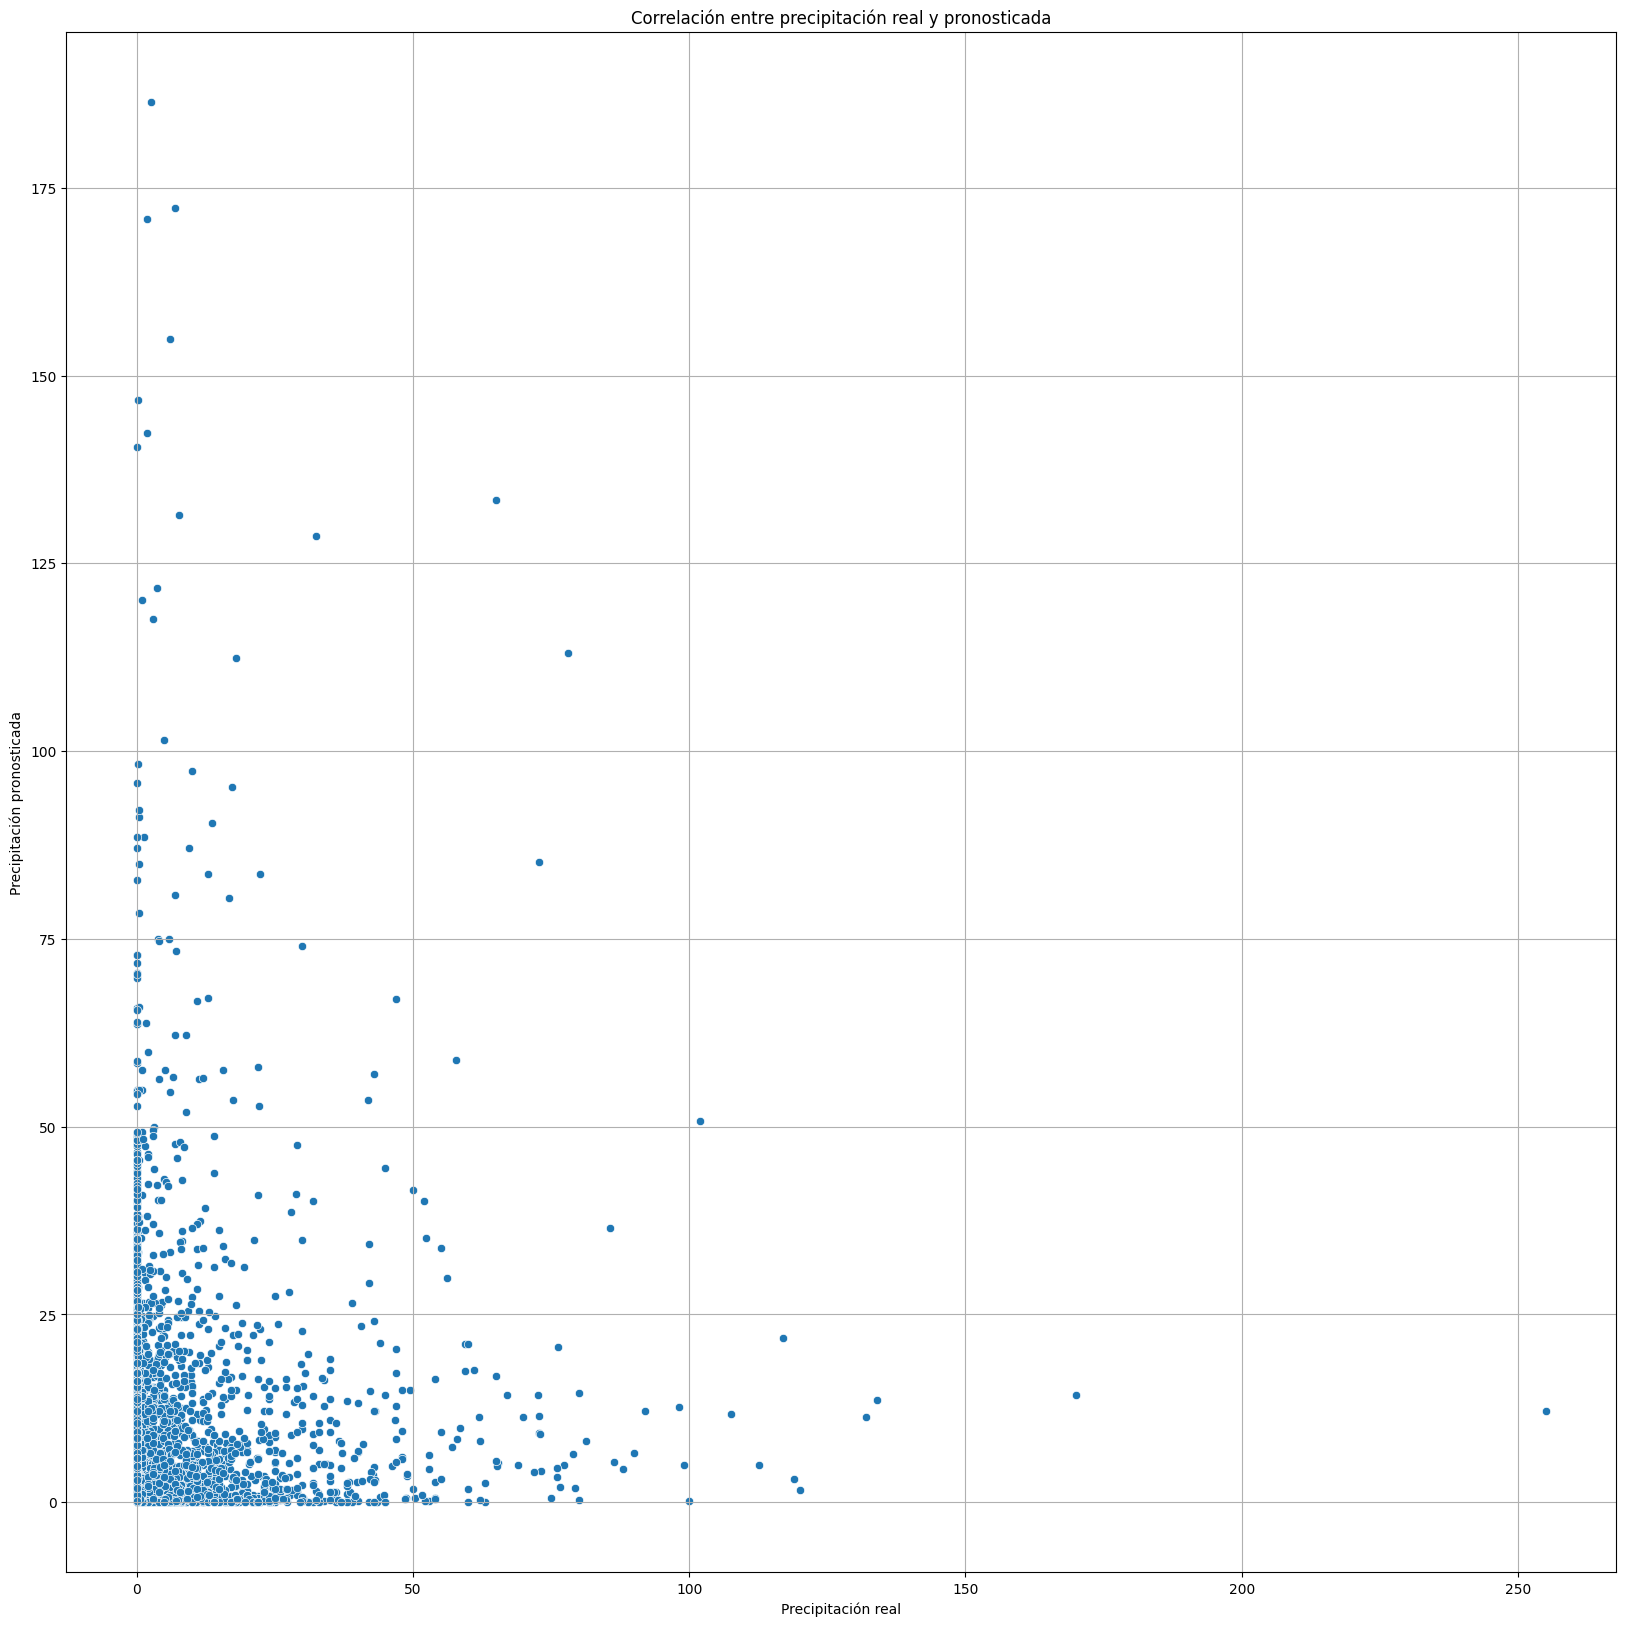

In [ ]:
# Calcula la correlación entre las columnas
correlation = df_corr['DATO_ESTACION'].corr(df_corr['DATO_RASTER'])

print("Correlación entre precipitación real y pronosticada:", correlation)

# Visualización de la correlación utilizando un gráfico de dispersión
plt.figure(figsize=(20, 20))
sns.scatterplot(data=df_corr, x='DATO_ESTACION', y='DATO_RASTER')
plt.title('Correlación entre precipitación real y pronosticada')
plt.xlabel('Precipitación real')
plt.ylabel('Precipitación pronosticada')
plt.grid(True)
plt.show()


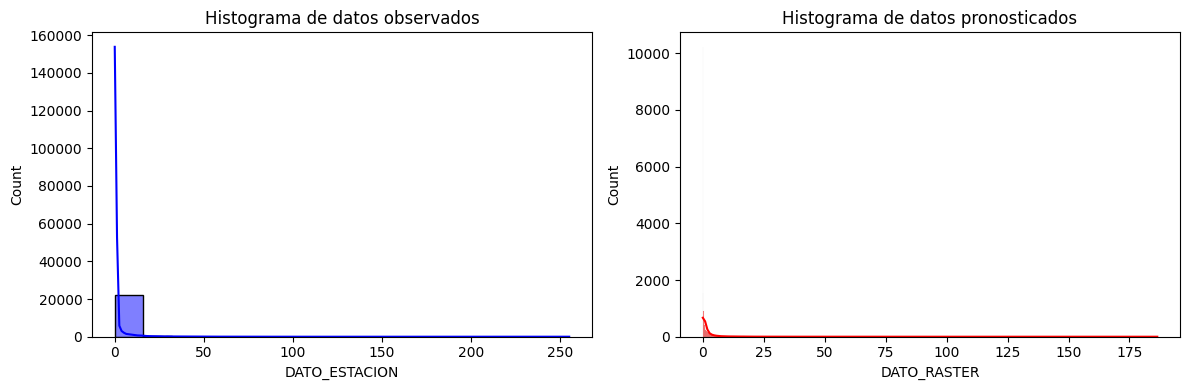

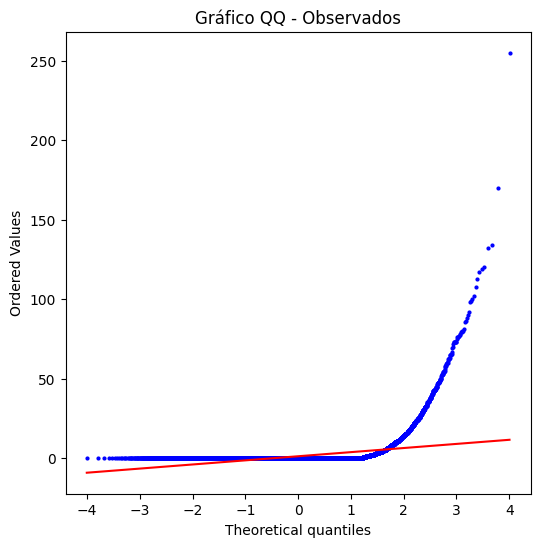

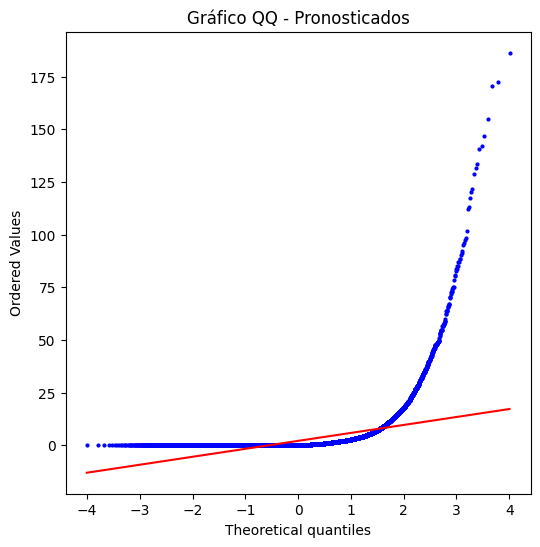

Valor p para datos observados: 0.0
Valor p para datos pronosticados: 0.0


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
observados = df_corr['DATO_ESTACION']
pronosticados = df_corr['DATO_RASTER']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(observados, kde=True, color='blue', label='Observados')
plt.title('Histograma de datos observados')

plt.subplot(1, 2, 2)
sns.histplot(pronosticados, kde=True, color='red', label='Pronosticados')
plt.title('Histograma de datos pronosticados')

plt.tight_layout()
plt.show()

# Gráfico QQ
plt.figure(figsize=(6, 6))
stats.probplot(observados, dist="norm", plot=plt)
plt.title('Gráfico QQ - Observados')
plt.gca().get_lines()[0].set_markersize(2)
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(pronosticados, dist="norm", plot=plt)
plt.title('Gráfico QQ - Pronosticados')
plt.gca().get_lines()[0].set_markersize(2)
plt.show()

# Prueba de normalidad
_, p_valor_observados = stats.shapiro(observados)
_, p_valor_pronosticados = stats.shapiro(pronosticados)

print("Valor p para datos observados:", p_valor_observados)
print("Valor p para datos pronosticados:", p_valor_pronosticados)

Los p valores de los datos observados y de los datos pronosticados(raster), son menores 0.05 por tanto los datos no se distribuyen normalmente. Pasamos a Aplicar entonces correlaciones para distribuciones no normales como spearman y kendall

In [ ]:
spearman_corr, spearman_p_valor = stats.spearmanr(observados, pronosticados)
print("Correlación de Spearman:", spearman_corr)
print("Valor p de Spearman:", spearman_p_valor)

Correlación de Spearman: 0.3460288530346573
Valor p de Spearman: 0.0


In [ ]:
kendall_corr, kendall_p_valor = stats.kendalltau(observados, pronosticados)
print("Correlación de Kendall:", kendall_corr)
print("Valor p de Kendall:", kendall_p_valor)

Correlación de Kendall: 0.2964519006686074
Valor p de Kendall: 0.0


Podemos concluir que hay una correlacion moderada entre los datos observados y pronosticados, lo cual quiere decir que aunque existe una relación esta no es extremadamente fuerte.

### **4.2.1 Análisis de regresiones**
---

Podriamos tomar como ejemplo el caso de la pluviosidad como funcion de la elevacion. Muchos autores han estudiado la asociación entre la elevación y la pluviosidad como un fenómeno complejo y multifacético que puede ser influenciado por una variedad de factores geográficos y climáticos. De manera general, se ha observado que en regiones de mayor altitud, la cantidad de precipitación tiende a ser mayor. Esto se debe en parte al efecto orográfico, donde las montañas interceptan corrientes de aire húmedo procedentes del océano, provocando la formación de nubes y, consecuentemente, aumentando la probabilidad de lluvia en las laderas expuestas al viento. Además, la elevación puede afectar los patrones de convección atmosférica, lo que contribuye a la formación de precipitación. Sin embargo, al llevar a cabo un analisis de correlacion, se puede evidenciar un valor de correlacion practicamente nulo entre las dos variables, con lo que seria dificil estimar el valor de la precipitacion conociendo la elevacion del lugar.

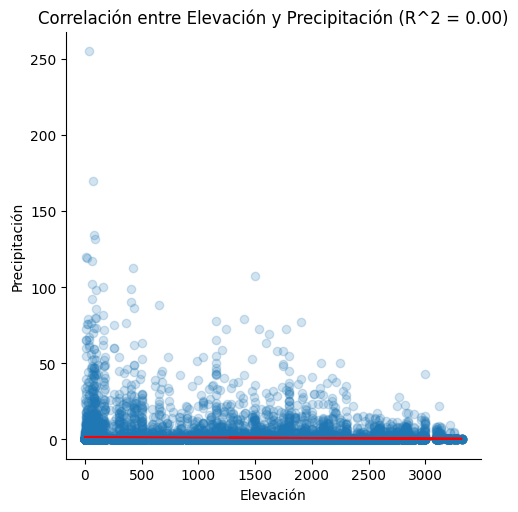

In [ ]:
df_corr = datos_validacion.copy()
correlacion = df_corr['ELEV'].corr(datos_validacion['DATO_ESTACION'])

# Gráfico de dispersión con línea de regresión
sns.lmplot(x='ELEV', y='DATO_ESTACION', data=df_corr, scatter_kws={'alpha':0.2})
plt.title('Correlación entre Elevación y Precipitación (R^2 = {:.2f})'.format(correlacion**2))
plt.xlabel('Elevación')
plt.ylabel('Precipitación')

slope, intercept, r_value, p_value, std_err = stats.linregress(df_corr['ELEV'], df_corr['DATO_ESTACION'])
plt.plot(df_corr['ELEV'], slope * df_corr['ELEV'] + intercept, color='red')

plt.show()


Se explica que debido a que las estaciones están geográficamente distantes y lógicamente bajo diferentes condiciones meteorológicas, resulta poco práctico realizar un análisis de correlación entre los datos observados y los datos raster. Del mismo modo, si se quisiera comparar la lluvia observada con la pronosticada, al tratarse de una comparación general de variables categóricas cuyos valores oscilan entre tiempo seco y lluvia torrencial, podrían utilizarse otras metodologías de relación. Por lo tanto, para fines prácticos del ejercicio, el equipo eligió arbitrariamente la estación "TAMBO" y realizó un análisis de correlación entre los datos observados y los datos raster en esta estación en particular durante todo el mes de enero. El valor obtenido indica una baja correlación entre los dos valores.

In [ ]:
# Filtramos el DataFrame por la estación "TAMBO"
datos_tambo = datos_validacion[datos_validacion['ESTACION'] == 'TAMBO']

# Calculamos la correlación entre las columnas "DATO_ESTACION" y "DATO_RASTER"
correlation = datos_tambo['DATO_ESTACION'].corr(datos_tambo['DATO_RASTER'])

# Extraemos el día de la fecha y agregarlo como una nueva columna y agregamos el grafico de correlacion
datos_tambo['DIA'] = datos_tambo['FECHA'].dt.day

plt.figure(figsize=(10, 6))
plt.scatter(datos_tambo['DIA'], datos_tambo['DATO_ESTACION'], label='DATO_ESTACION')
plt.scatter(datos_tambo['DIA'], datos_tambo['DATO_RASTER'], label='DATO_RASTER')
plt.xlabel('Día')
plt.ylabel('Escala')
plt.title('Correlación entre DATO_ESTACION y DATO_RASTER en la estación TAMBO')
plt.legend()
plt.show()

print(f"Correlación entre DATO_ESTACION y DATO_RASTER: {correlation}")

### **4.3. Análisis de resultados y cumplimiento de los objetivos:**

---El entendimiento y la preparación de los datos pluviométricos de las estaciones meteorológicas en el mes de enero son fundamentales para diversos fines, como el análisis climático, la planificación de actividades agrícolas, la gestión de recursos hídricos y la evaluación de riesgos naturales como inundaciones. La transformación de los datos cumple con el protocolo establecido por el IDEAM (modelo SmartMet), el cual requiere categorizar los niveles pluviométricos, una variable continua, en diferentes valores como Tiempo seco, Muy Ligera, Ligera, Moderada, Fuerte, Muy Fuerte y Sin Dato. Estos códigos permiten determinar globalmente el porcentaje de exactitud, la probabilidad de acierto y el sesgo en cada categoría, lo que proporciona métricas útiles para la evaluación y el seguimiento del comportamiento de las lluvias. Estas métricas obedecen al protocolo establecido para garantizar la calidad y consistencia de los datos meteorológicos.


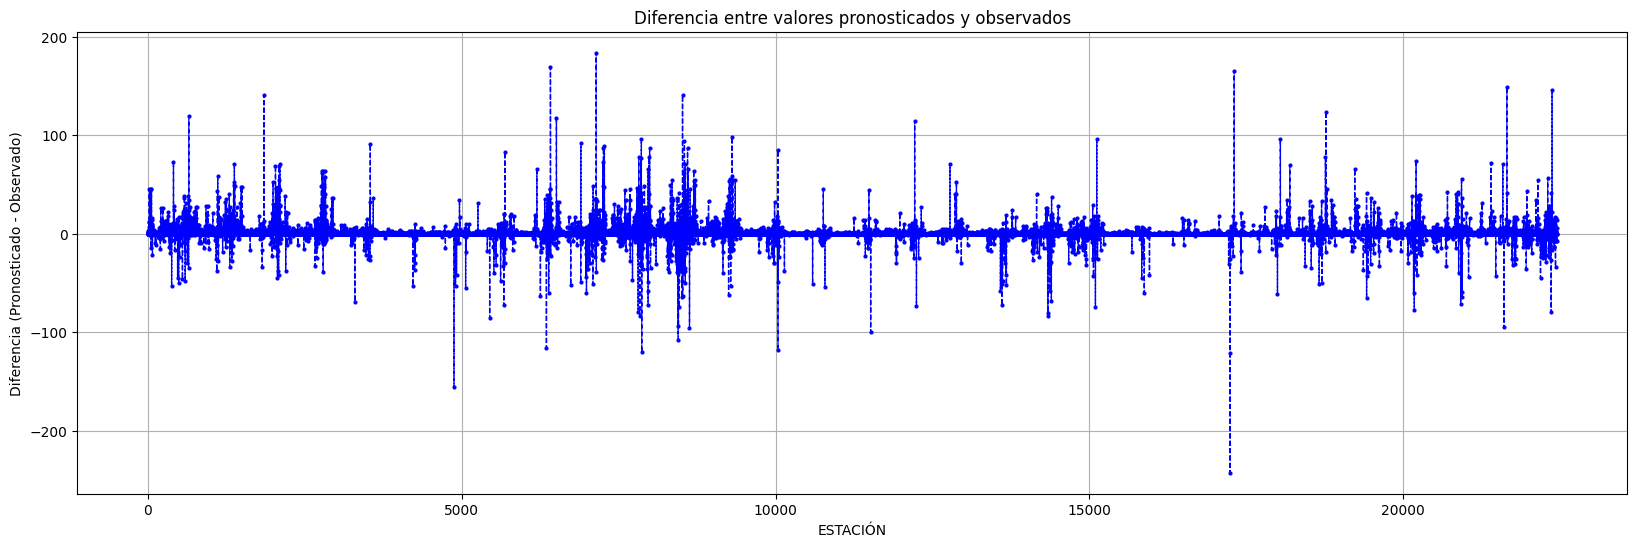

In [ ]:
diferencia = pronosticados - observados

plt.figure(figsize=(20, 6))
plt.plot(diferencia, color='blue', marker='o', linestyle='--', markersize=2, linewidth=1 )
plt.title('Diferencia entre valores pronosticados y observados')
plt.xlabel('ESTACIÓN')
plt.ylabel('Diferencia (Pronosticado - Observado)')
plt.grid(True)
plt.show()

Si bien hay un nivel de correspondecia entre datos pronosticados y reales de las estaciones.La diferencia de error nos muestra que tanttoe el modelo de pronostico como probalblemente el aumento de estaciones y observaciones podria aumentarse en aquellas regiones con malyor variabilidad entre pronostico y la observación

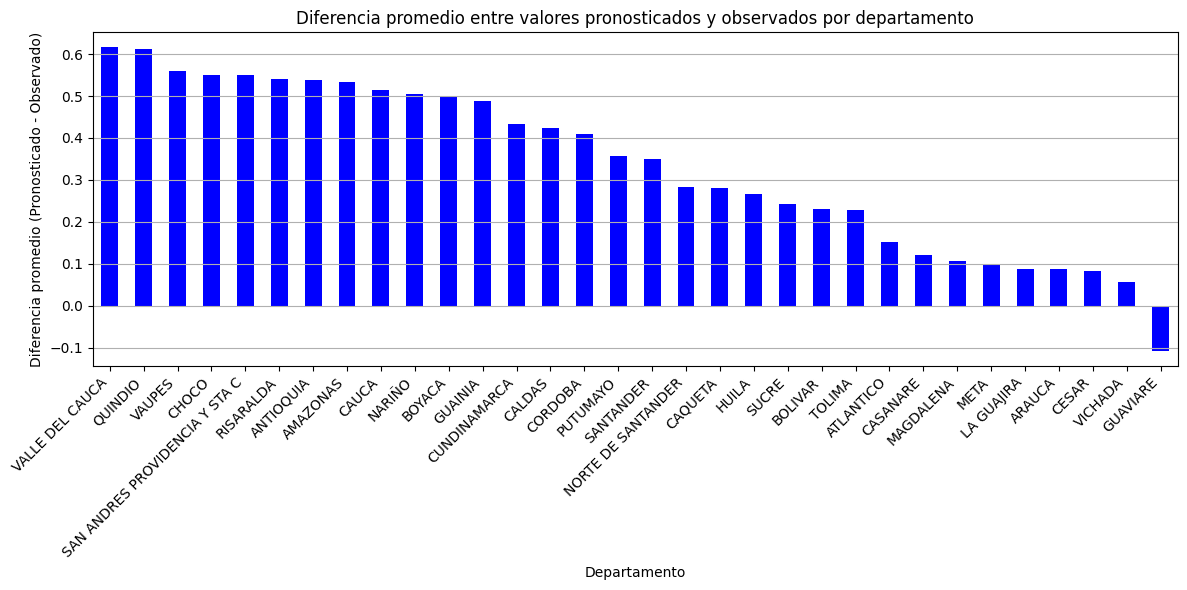

In [ ]:
diferencia_por_departamento = df_corr.groupby('DPTO')['lluvia_pronosticada_num'].mean() - df_corr.groupby('DPTO')['lluvia_observada_num'].mean()
diferencia_absoluta_por_departamento = abs(diferencia_por_departamento)
departamentos_ordenados  = diferencia_absoluta_por_departamento.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
diferencia_por_departamento_ordenada.plot(kind='bar', color='blue')
plt.title('Diferencia promedio entre valores pronosticados y observados por departamento')
plt.xlabel('Departamento')
plt.ylabel('Diferencia promedio (Pronosticado - Observado)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Aunque podria entrarse en mayor detalle sobre la relacion del error pronosticado promedio por region. La grafica anterior nos muestra los departamentos con mayor error en el promedio corresponded a zonas apartadas tradicionalmenty los que tienden a ubicarse en el medio a zonas centrales con pobrablemente mayor desarrollo. bvaldria la pena estudiar en un futuro analisis la cantidad de estaciones en relacion con la calidad y cantitidad de laobservacionde de las estaciones vs los pronosticos del modelo de clima.

**Evaluación de cumplimeiento de objetivos:**


Se alcanzó el objetivo de validar y visualizar la exactitud de los insumos metodológicos se cumplió contrastando los valores reales de las estaciones utilizando tanto tablas de contingencia como el error medio cuadrático.


Se logró establecer un método de acceso y descarga a los datos en formato raster, los cuales se usaron en el proceso de comparación.


También se aplicaron análisis de correlación y regresión para los datos observados y pronosticado encontrando que aunque existe una relación, no es extremadamente fuerte.


Se aplicaron pruebas de normalidad como Shapiro-Wilk y se encontró que los datos no se distribuyen normalmente.


Se intentó analizar la relación entre la elevación y la cantidad de lluvia, sin embargo, la correlación entre estas variables resultó ser prácticamente nula, lo que indica que la elevación por sí sola no es un predictor confiable de la cantidad de lluvia.


Podemos en efecto decir que se realizó un evaluación de la precisión del modelo de predicción de lluvia


Se utilizaron métricas como el Error Absoluto Medio (MAE) y la Raíz del Error Cuadrático Medio (RMSE) para evaluar la precisión del modelo de predicción de lluvia. El MAE resultó ser 2.44 mm y el RMSE fue de 8.43 mm, lo que indica que el modelo tiene un cierto grado de error en sus predicciones.


La tabla de contingencia mostró una precisión del 57.44% para predecir correctamente la categoría "Tiempo Seco". Relación entre la lluvia observada y pronosticada:


## **5. Visualización de datos**
---

### **5.1. Abstracción y definición de las visualizaciones:**

---


1. **Distribucion del error:** Esta gráfica muestra la distribución del error, que se calcula a través de la diferencia entre la lluvia observada y la lluvia pronosticada. Se puede visualizar el resultado obtenido previamente del Error Absoluto Medio (MAE), que es 2.4 mm. Sin embargo, el valor graficado es negativo ya que no se toma en cuenta el valor absoluto, lo que podría evidenciar una mayor subestimación en el pronóstico de lluvias.

2. **Comportamiento de la lluvia observada y pronosticada por estación:** Esta gráfica interactiva permite seleccionar cada una de las estaciones disponible y muestra el comportamiento de la lluvia observada correspondiente al dato real reportado por la estacion meteorológica, la lluvia pronosticada correspondiente al dato del raster de pronostico para cada fecha registrada y el MAE(Media del valor absoluto) de todas las fechas registradas para cada estación.

3. **Histograma de evaluación:** Esta gráfica muestra la distribución de la evaluación que se realizó entre la lluvia pronosticada y la lluvia observada, teniendo en cuenta umbrales definidos a partir de los percentiles [0.7, 0.8, 0.9, 0.95, 0.99]. Las categorías utilizadas son: ‘Tiempo Seco’, ‘Muy Ligera’, ‘Ligera’, ‘Moderada’, ‘Fuerte’, ‘Muy Fuerte’ y ‘Torrencial’. Los aciertos corresponden al porcentaje de estaciones donde la categoría pronosticada es igual a la observada. Los diferentes niveles de subestimación y sobreestimación indican cuánto se alejó la categoría pronosticada de la observada.

4. **Evaluación de la predicción de la lluvia:** La gráfica superior muestra la evaluación que se realizó entre la lluvia pronosticada y la lluvia observada durante el mes de enero de 2024, teniendo en cuenta umbrales definidos a partir de los percentiles [0.7, 0.8, 0.9, 0.95, 0.99]. Las categorías utilizadas son: ‘Tiempo Seco’, ‘Muy Ligera’, ‘Ligera’, ‘Moderada’, ‘Fuerte’, ‘Muy Fuerte’ y ‘Torrencial’. Los aciertos corresponden al porcentaje de estaciones donde la categoría pronosticada es igual a la observada. Los diferentes niveles de subestimación y sobreestimación indican cuánto se alejó la categoría pronosticada de la observada. Ademas, en la gráfica inferior se muestra el comportamiento de los aciertos en la prediccion a lo largo del mes, teniendo de referencia su valor medio mensual.

### **5.2. Visualización de la información estática e interactiva:**

---


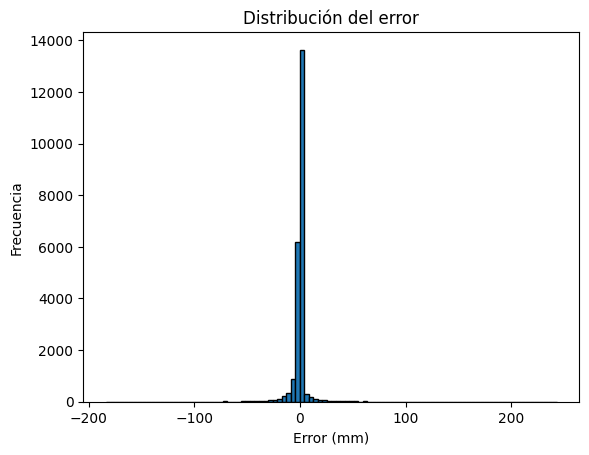

In [ ]:
# Histograma del error
plt.hist(error, bins=100, edgecolor='black')
plt.xlabel('Error (mm)')
plt.ylabel('Frecuencia')
plt.title('Distribución del error')
plt.show()

In [ ]:
# Leer el archivo CSV
df = datos_validacion

# Convertir la columna 'FECHA' a datetime
df['FECHA'] = pd.to_datetime(df['FECHA'])

# Función para graficar los datos de una estación
def graficar(estacion):
    data = df[df['ESTACION'] == estacion]
    # Calcular el error absoluto entre el valor real y el pronosticado para todos los datos
    error_absoluto_total = abs(data ['DATO_ESTACION'] - data ['DATO_RASTER'])

    # Calcular la media del error absoluto total
    media_error_total = error_absoluto_total.mean()

    fig, ax = plt.subplots(figsize=(10, 5))

    # Agregar marcas en círculos para los datos de cada fecha
    ax.plot(data['FECHA'], data['DATO_ESTACION'], 'o', color='blue', label='Dato Real')

    # Cambiar el marcador de la pronosticada a un rombo
    ax.plot(data['FECHA'], data['DATO_RASTER'], 'd', color='red', label='Dato Pronosticado')

    # Mostrar la media del error total con una línea punteada en el mismo eje Y
    ax.axhline(y=media_error_total, linestyle='--', color='green', label='Error Absoluto Medio')

    # Ajustar los ticks del eje X para que se muestren cada 5 días
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Ajustar el límite inferior del eje X para que comience desde la primera fecha
    ax.set_xlim(data['FECHA'].min() - pd.DateOffset(days=1), data['FECHA'].max() + pd.DateOffset(days=1))

    # Ajustar la orientación y el tamaño de las etiquetas del eje X
    plt.setp(ax.get_xticklabels(), rotation='horizontal', fontsize=10)

    plt.xlabel('Fecha')
    plt.ylabel('Precipitación (mm)')
    plt.title(f'Comportamiento de la lluvia observada y pronosticada\nEstación: {estacion}')
    plt.legend()
    plt.show()

# Crear el selector interactivo
interact(graficar, estacion=df['ESTACION'].unique())


interactive(children=(Dropdown(description='estacion', options=('APTO GUSTAVO ROJA PINILLA', 'APTO EL EMBRUJO'…

<function __main__.graficar(estacion)>

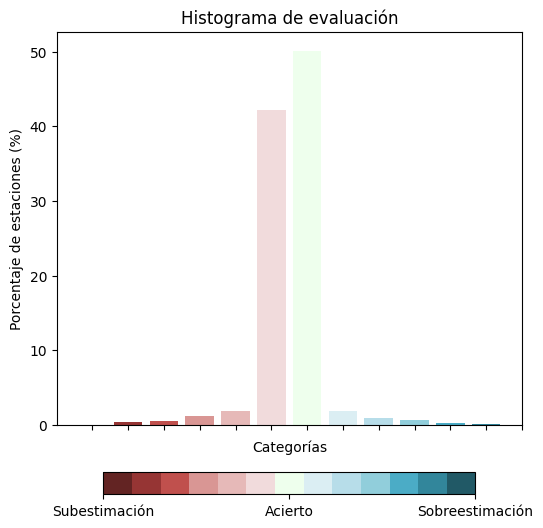

In [ ]:
# Ajustar el tamaño de la figura
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(100, 100)
ax = fig.add_subplot(gs[:85, :])

# Calcular los porcentajes para cada categoria
categorias = range(-6, 7)
porcentajes = datos_validacion['evaluacion'].value_counts(normalize=True).fillna(0) * 100
porcentajes = porcentajes.sort_index()

# Generar una gama de colores
subest = ["#632423", "#963534", "#c0504d", "#d99694", "#e6b9b8", "#f1dbdc"]
sobreest = ["#dbeef3", "#b7dde9", "#91cedb", "#4bacc6", "#32869b", "#215966"]
colores = subest + ['#eeffed'] + sobreest

#Ajustar ejes
ax.bar(porcentajes.index, porcentajes.values, color=colores)
ax.set_xticklabels([])
ax.set_xlabel('Categorías')
ax.set_ylabel('Porcentaje de estaciones (%)')
ax.set_title('Histograma de evaluación')
ax.set_xticks(list(categorias))

# Crear la leyenda
cax = fig.add_subplot(gs[95:, 10:90])
cmap = ListedColormap(colores)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-6, vmax=6))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal', ticks=[-6, 0, 6])
cbar.set_ticklabels(['Subestimación', 'Acierto', 'Sobreestimación'])

plt.show()


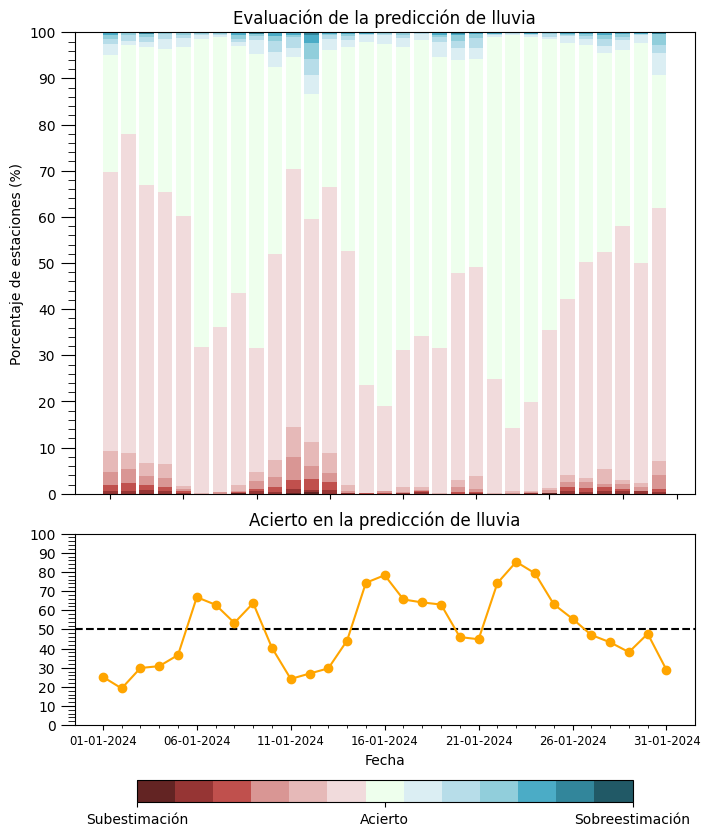

In [ ]:
# Calcular el porcentaje de cada categoría para cada fecha
categorias = range(-6, 7)
porcentajes = datos_validacion.groupby(['FECHA'])['evaluacion'].value_counts(normalize=True).unstack().fillna(0) * 100

# Asegurarse de que todas las categorías estén presentes
for categoria in categorias:
    if categoria not in porcentajes.columns:
        porcentajes[categoria] = 0

# Crear la gráfica de barras apilada
fig = plt.figure(figsize=(8, 10))

gs = fig.add_gridspec(100, 100)

ax = fig.add_subplot(gs[:60, :])

# Genera una gama de colores
subest = ["#632423", "#963534", "#c0504d", "#d99694", "#e6b9b8", "#f1dbdc"]
sobreest = ["#dbeef3", "#b7dde9", "#91cedb", "#4bacc6", "#32869b", "#215966"]
colores = subest + ['#eeffed'] + sobreest

# Apilar las barras
for i, categoria in enumerate(categorias):
    ax.bar(porcentajes.index, porcentajes[categoria], bottom=porcentajes[categorias[:i]].sum(axis=1), color=colores[i])

# Ajustar ejes
yticks = np.arange(0, 101, 10)
yticks_minor = np.arange(0, 101, 2)
ax.set_yticks(yticks)
ax.set_yticks(yticks_minor, minor=True)
ax.get_yaxis().set_tick_params(which='major', size=10)
ax.get_yaxis().set_tick_params(which='minor', size=5)
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('Porcentaje de estaciones (%)')
ax.set_title('Evaluación de la predicción de lluvia')

# Crear la gráfica vacía
ax2 = fig.add_subplot(gs[65:90, :])

# Calcular el valor medio de acierto para todas las fechas
media_acierto = porcentajes[0].mean()

# Dibujar la línea punteada para el valor medio
ax2.axhline(y=media_acierto, color='k', linestyle='--')

# Dibujar los valores diarios
ax2.plot(porcentajes.index, porcentajes[0], marker='o', color='orange')

# Ajustar ejes
fechas = porcentajes.index
ax2.set_xticks(fechas, minor=True)
ax2.set_xticks(fechas[::5])
ax2.set_xticklabels(fechas[::5], rotation=0, fontsize='small')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax2.set_yticks(yticks)
ax2.set_yticks(yticks_minor, minor=True)
ax2.get_yaxis().set_tick_params(which='major', size=10)
ax2.get_yaxis().set_tick_params(which='minor', size=5)
ax2.set_ylabel('')
ax2.set_title('Acierto en la predicción de lluvia')
ax2.set_xlabel('Fecha')

# Crear la leyenda
cax = fig.add_subplot(gs[97:, 10:90])
cmap = ListedColormap(colores)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-6, vmax=6))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal', ticks=[-6, 0, 6])
cbar.set_ticklabels(['Subestimación', 'Acierto', 'Sobreestimación'])

plt.show()
